# Tutorial on Radio Maps

In this notebook, you will learn how to

- Compute and configure radio maps
- Visualize different radio map metrics, such as path gain, received signal
  strength (RSS), and signal-to-interference-plus-noise ratio (SINR)
- Interpret radio map-based user-to-transmitter association
- Understand the effects of precoding vectors on radio maps
- Sample user positions from a radio map according to various criteria
- Generate channel impulse responses for sampled user positions

## Imports

In [ ]:
import numpy as np
import mitsuba as mi
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

from sionna.rt import load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver, load_mesh, watt_to_dbm, transform_mesh,\
                      cpx_abs_square

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

## Understanding radio maps

A [radio map](https://nvlabs.github.io/sionna/rt/api/radio_maps.html)
assigns a metric, such as path gain, received signal strength (RSS), or
signal-to-interference-plus-noise ratio (SINR), for a specific transmitter to
every point on a plane. In other words, for a given transmitter, it associates
every point on a surface with the channel gain, RSS, or SINR, that a receiver
with a specific orientation would observe at this point. 

A radio map depends on the transmit and receive arrays and their respective
antenna patterns, the transmitter and receiver orientations, as well as the
transmit precoding and receive combining vectors. Moreover, a radio map is
not continuous but discrete, as the plane must be quantized into small
rectangular bins, which we refer to as *cells*.

As a first example, we load an empty scene, place a single transmitter in it,
and compute a coverage map.

In [1]:
scene = load_scene() # Load empty scene

# Configure antenna arrays for all transmitters and receivers
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             pattern="iso",
                             polarization="V")
scene.rx_array = scene.tx_array

# Define and add a first transmitter to the scene
tx0 = Transmitter(name='tx0',
                  position=[150, -100, 20],
                  orientation=[np.pi*5/6, 0, 0],
                  power_dbm=44)
scene.add(tx0)

# Compute radio map
rm_solver = RadioMapSolver()
rm = rm_solver(scene,
               max_depth=5,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[0, 0, 0],      # Center of the radio map
               size=[400, 400],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical


KeyboardInterrupt



### Metrics

There are several ways to visualize a radio map. The simplest option is to call the class method
[show()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.show)
for the desired metric.

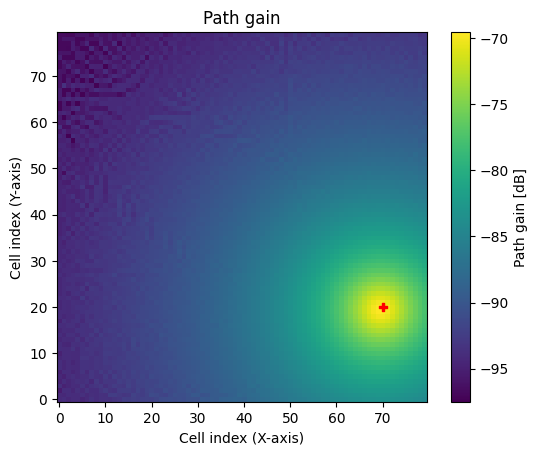

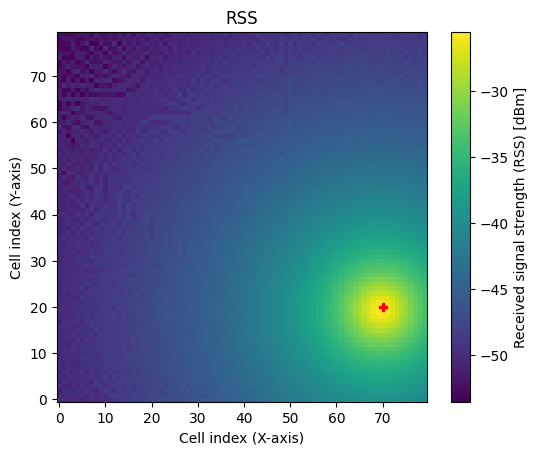

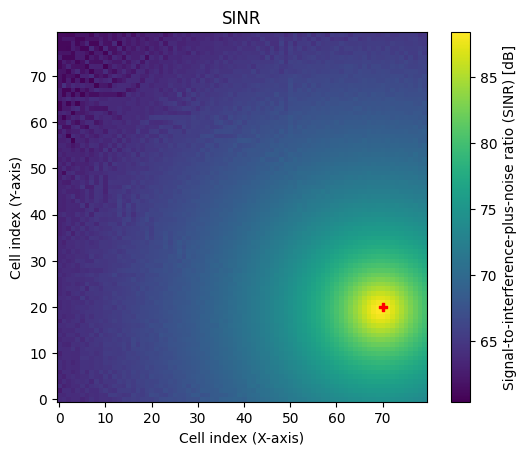

In [3]:
# Visualize path gain
rm.show(metric="path_gain");

# Visualize received signal strength (RSS)
rm.show(metric="rss");

# Visulaize SINR
rm.show(metric="sinr");

The RSS depends on the transmit power which can be modified for each
transmitter as shown below.

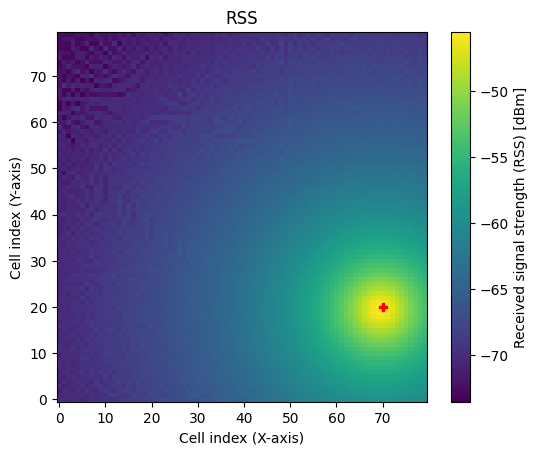

In [4]:
tx0.power_dbm = 24
rm = rm_solver(scene,
               max_depth=5,           
               samples_per_tx=10**7,
               cell_size=(5, 5),     
               center=[0, 0, 0],      
               size=[400, 400],       
               orientation=[0, 0, 0]) 
rm.show(metric="rss");

Compared to the previous cell, the RSS is now 20dB smaller.

The SINR depends not only on the RSS from other transmitters in the scene but
also on the thermal noise power. The noise power is configured indirectly via the scene
properties [bandwidth](https://nvlabs.github.io/sionna/rt/api/scene.html#sionna.rt.Scene.bandwidth) and [temperature](https://nvlabs.github.io/sionna/rt/api/scene.html#sionna.rt.Scene.temperature). 

Note that neither parameter affects the ray tracing process; they are only used for the computation of the noise power.

In [5]:
print(f"Bandwidth: ", scene.bandwidth.numpy(), "[Hz]")
print(f"Temperature: ", scene.temperature.numpy(), "[K]")
print(f"Thermal noise power: ", watt_to_dbm(scene.thermal_noise_power).numpy(), "[dBm]")

Bandwidth:  [1000000.] [Hz]
Temperature:  [293.] [K]
Thermal noise power:  [-113.9305] [dBm]


All metrics of a radio map can be directly accessed as tensors as shown in
the next cell. This can be useful to define new metrics or visualize metrics in
a different form, such as CDF plots, etc.

In [6]:
# Metrics have the shape
# [num_tx, num_cells_y, num_cells_x]

print(f'{rm.path_gain.shape=}') # Path gain
print(f'{rm.rss.shape=}') # RSS
print(f'{rm.sinr.shape=}') # SINR

# The location of all cell centers in the global coordinate system of the scene 
# can be accessed via:
# [num_cells_y, num_cells_x, 3]
print(f'{rm.cell_centers.shape=}')

rm.path_gain.shape=(1, 80, 80)
rm.rss.shape=(1, 80, 80)
rm.sinr.shape=(1, 80, 80)
rm.cell_centers.shape=(80, 80, 3)


### Multiple transmitters

To make things more interesting, let us add two more transmitters
to the scene and recompute the radio map.

In [7]:
# Remove transmitters here so that the cell can be executed multiple times
scene.remove("tx1")
scene.remove("tx2")

tx1 = Transmitter(name='tx1',
                  position=[-150, -100, 20],
                  orientation=[np.pi/6, 0, 0],
                  power_dbm=21)
scene.add(tx1)

tx2 = Transmitter(name='tx2',
                  position=np.array([0, 150 * np.tan(np.pi/3) - 100, 20]),
                  orientation=[-np.pi/2, 0, 0],
                  power_dbm=27)
scene.add(tx2)

rm = rm_solver(scene,
               max_depth=5,           
               samples_per_tx=10**7,
               cell_size=(5, 5),     
               center=[0, 0, 0],      
               size=[400, 400],       
               orientation=[0, 0, 0]) 

As soon as there are multiple transmitters in a scene, we can either visualize
a metric for specific transmitter or visualize the maximum metric across all
transmitters. The latter option is relevant if we want to inspect, e.g., the SINR across a large
scene, assuming that a receiver always connects to the transmitter providing
the best SINR.

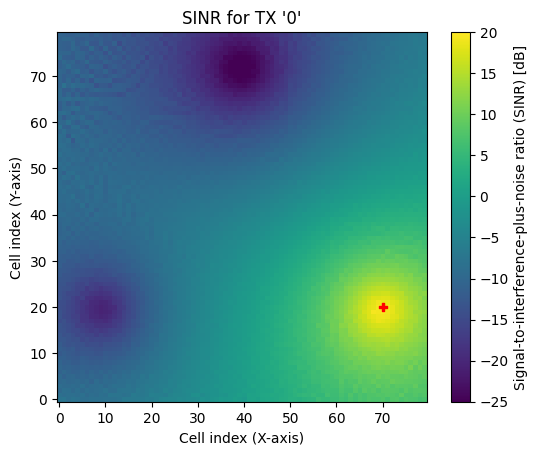

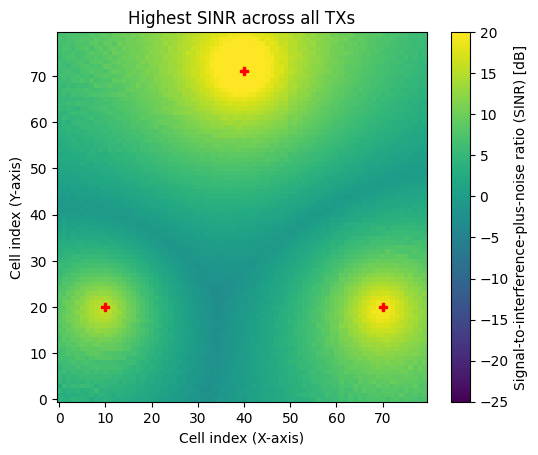

In [8]:
# Show SINR for tx0
rm.show(metric="sinr", tx=0, vmin=-25, vmax=20);

# Show maximum SINR across all transmitters
rm.show(metric="sinr", tx=None, vmin=-25, vmax=20);

# Experiment: Change the metric to "path_gain" or "rss"
#             and play around with the parameters vmin/vmax
#             that determine the range of the colormap

We can also visualize the cumulative distribution function (CDF) of the metric of interest:

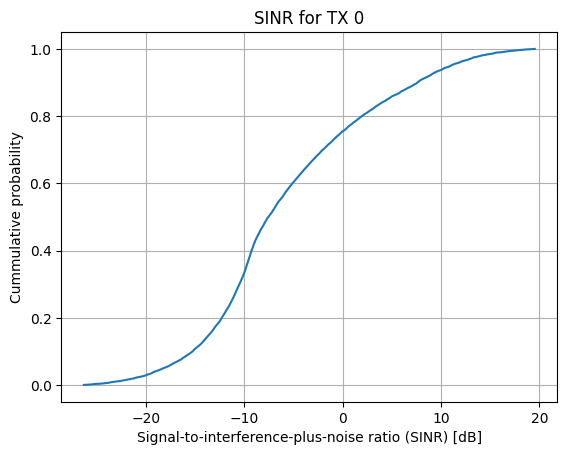

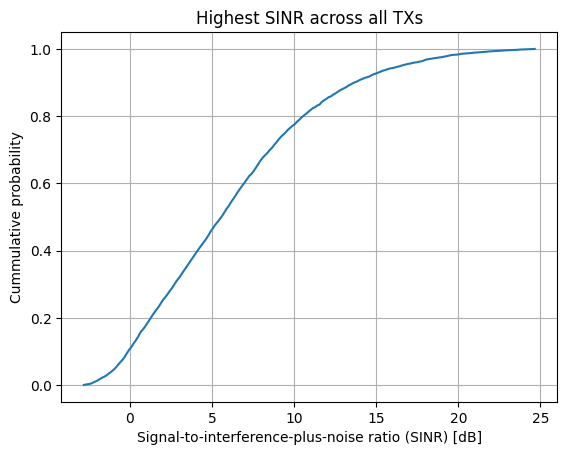

In [9]:
# CDF of the SINR for transmitter 0
rm.cdf(metric="sinr", tx=0);

# CDF of the SINR if always the transmitter providing the best SINR is selected
rm.cdf(metric="sinr");

Note that, at every position, the highest SINR across *all* transmitters is
always more favorable than the SINR offered by a *specific* transmitter (in math terms, the
former *stochastically dominates* the latter). This is clearly reflected in the
shape of the two distributions.

### User association

It is also interesting to investigate which regions of a radio map are "covered" by each transmitter, i.e., where a transmitter provides the strongest metric. 
You can obtain this information either as a tensor from the class method [tx_association()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.tx_association) or visualize it using [show_association()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.show_association).

rm.tx_association("sinr").shape=(80, 80)


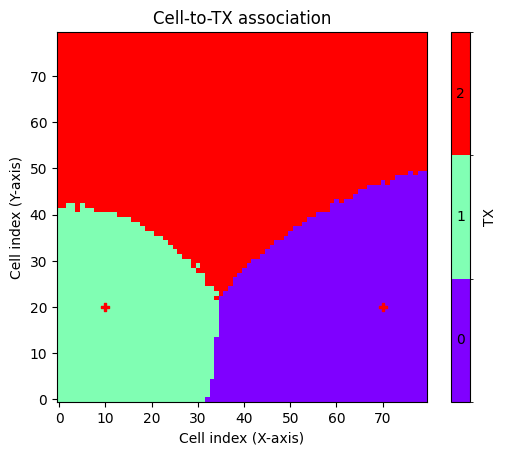

In [10]:
# Get for every cell the tx index providing the strongest value
# of the chosen metric
# [num_cells_y, num_cells_x]
print(f'{rm.tx_association("sinr").shape=}')

rm.show_association("sinr");

### Sampling of random user positions

In some cases, one may want to drop receivers at random positions in a scene
while ensuring that the chosen positions have sufficient signal quality
(e.g., SINR)
and/or or are located within a certain range of a transmitter. The class
method [sample_positions()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.sample_positions) is designed for this purpose, and you will see in the next
cell how it can be used.

You are encouraged to understand why the two different criteria used for sampling lead to the observed results. 

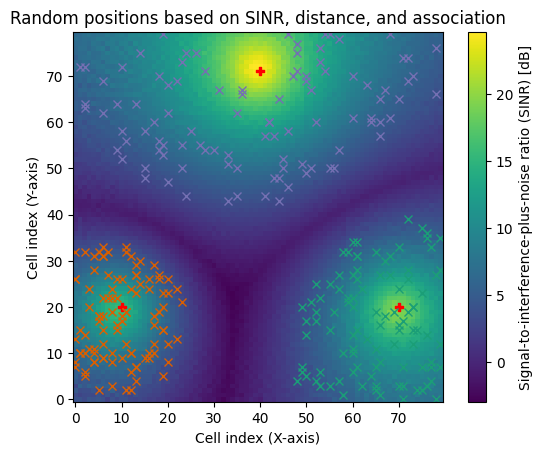

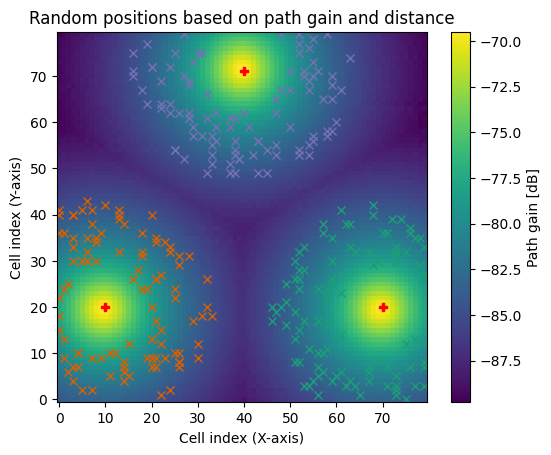

In [11]:
pos, cell_ids = rm.sample_positions(
          num_pos=100,         # Number of random positions per receiver
          metric="sinr",       # Metric on which constraints and TX association will be applied
          min_val_db=3,        # Mininum value for the chosen metric
          max_val_db=20,       # Maximum value for the chosen metric
          min_dist=10,         # Minimum distance from transmitter
          max_dist=200,        # Maximum distance from transmitter
          tx_association=True, # If True, only positions associated with a transmitter are chosen,
                               # i.e., positions where the chosen metric is the highest among all TXs
          center_pos=False)    # If True, random positions correspond to cell centers,
                               # otherwise a random offset within each cell is applied

fig = rm.show(metric="sinr");
plt.title("Random positions based on SINR, distance, and association")
# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])


pos, cell_ids = rm.sample_positions(
          num_pos=100,          # Number of random positions per receiver
          metric="path_gain",   # Metric on which constraints will be applied
          min_val_db=-85,        # Mininum value for the chosen metric
          min_dist=50,          # Minimum distance from transmitter
          max_dist=200,         # Maximum distance from transmitter
          tx_association=False, # If False, then a user located in a sampled position 
                                # for a specific TX may perceive a higher metric from another TX!
          center_pos=False)     # If True, random positions correspond to cell centers,
                                # otherwise a random offset within each cell is applied

fig = rm.show(metric="path_gain");
plt.title("Random positions based on path gain and distance")
# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])

### Directional antennas and precoding vectors

As mentioned above, radio maps heavily depend on the chosen antenna patterns and precoding vectors.
In the next cell, we will study their impact on a radio map via several visualizations. 

Let us start by assigning a single antenna to all transmitters and computing the
corresponding radio map:

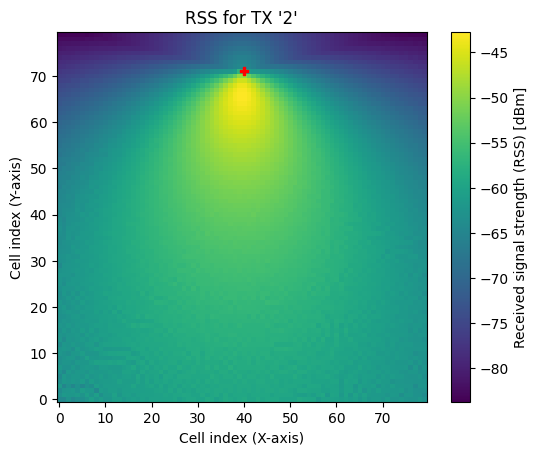

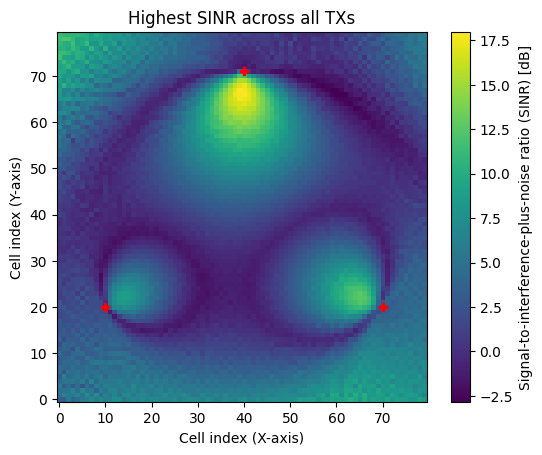

In [12]:
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",   # Change to "iso" and compare the results
                             polarization="V")

rm = rm_solver(scene,
               max_depth=5,           
               samples_per_tx=10**7,
               cell_size=(5, 5),     
               center=[0, 0, 0],      
               size=[400, 400],       
               orientation=[0, 0, 0]) 

rm.show(metric="rss", tx=2);

rm.show(metric="sinr");

We now add more antennas to the antenna array of the transmitters and apply a
precoding vector chosen from a Discrete Fourier Transform (DFT) beam grid.

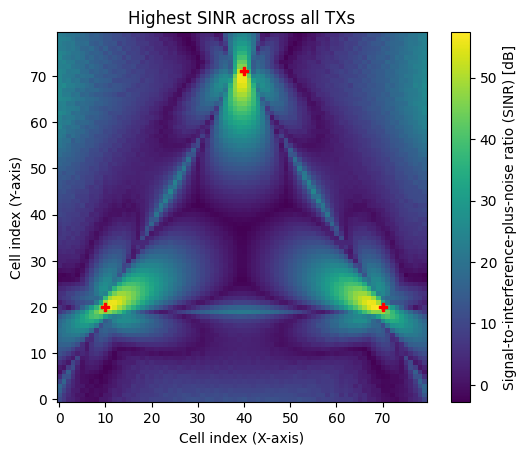

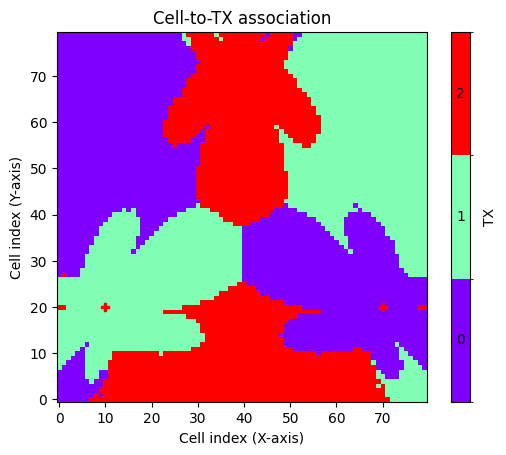

In [13]:
# Number of elements of the rectangular antenna array
num_rows = 2
num_cols = 4

# Configure all transmitters to have equal power
tx0.power_dbm = 23
tx1.power_dbm = 23
tx2.power_dbm = 23

# Configure tr38901 uniform rectangular antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=num_rows,
                             num_cols=num_cols,
                             pattern="tr38901",
                             polarization="V")

# Create a common precoding vector used by all transmitters
# It is also possible to assign individual
precoding_vec = [1, -1]*4 / np.sqrt(8)

# Convert to tuple of Mitsuba vectors
precoding_vec = (mi.TensorXf(precoding_vec.real),
                 mi.TensorXf(precoding_vec.imag))

# Compute the radio map
rm = rm_solver(scene,
               max_depth=5,           
               samples_per_tx=10**7,
               precoding_vec=precoding_vec,
               cell_size=(5, 5),     
               center=[0, 0, 0],      
               size=[400, 400],       
               orientation=[0, 0, 0]) 

rm.show(metric="sinr");
rm.show_association(metric="sinr");

The use of antenna arrays and precoding vectors leads to complicated, even
artistic looking, radio maps with sometimes counter-intuitive regions of user
association. Nevertheless, we can still sample user positions for each transmitter.

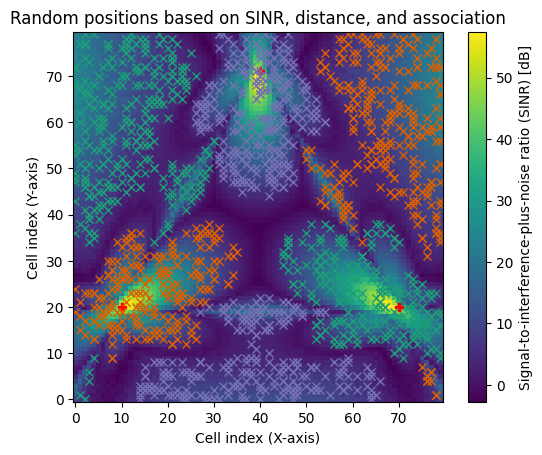

In [14]:
pos, cell_ids = rm.sample_positions(
          num_pos=500,         
          metric="sinr",       
          min_val_db=3,        
          min_dist=10,         
          tx_association=True)

fig = rm.show(metric="sinr");

# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])
plt.title("Random positions based on SINR, distance, and association");

## Radio map for a realistic scene

Until now, we have only looked at radio maps in an empty scene. Let's spice things up a little bit
and load a more interesting scene, place transmitters, and inspect the results.

In [15]:
def config_scene(num_rows, num_cols):
    """Load and configure a scene"""
    scene = load_scene(sionna.rt.scene.etoile)
    scene.bandwidth=100e6
    
    # Configure antenna arrays for all transmitters and receivers
    scene.tx_array = PlanarArray(num_rows=num_rows,
                                 num_cols=num_cols,
                                 pattern="tr38901",
                                 polarization="V")
    
    scene.rx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 pattern="iso",
                                 polarization="V")

    # Place transmitters
    positions = np.array(
                 [[-150.3, 21.63, 42.5],
                  [-125.1, 9.58, 42.5],
                  [-104.5, 54.94, 42.5],
                  [-128.6, 66.73, 42.5],
                  [172.1, 103.7, 24],
                  [232.8, -95.5, 17],
                  [80.1, 193.8, 21]
                 ])
    look_ats = np.array(
                [[-216, -21,0],
                 [-90, -80, 0],
                 [-16.5, 75.8, 0],
                 [-164, 153.7, 0],
                 [247, 92, 0],
                 [211, -180, 0],
                 [126.3, 194.7, 0]
                ])
    power_dbms = [23, 23, 23, 23, 23, 23, 23]

    for i, position in enumerate(positions):
        scene.add(Transmitter(name=f'tx{i}',
                              position=position,
                              look_at=look_ats[i],
                              power_dbm=power_dbms[i]))

    return scene  

In [16]:
# Load and configure scene
num_rows=8
num_cols=2
scene_etoile = config_scene(num_rows, num_cols)

# Compute the SINR map
rm_etoile = rm_solver(scene_etoile,
                      max_depth=5,           
                      samples_per_tx=10**7,
                      cell_size=(1, 1))

To get a global view of the coverage, let us visualize the radio map in the preview (or  rendered image). These are alternatives to the [show()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.show) method we have used until now, which also visualizes the objects in a scene.

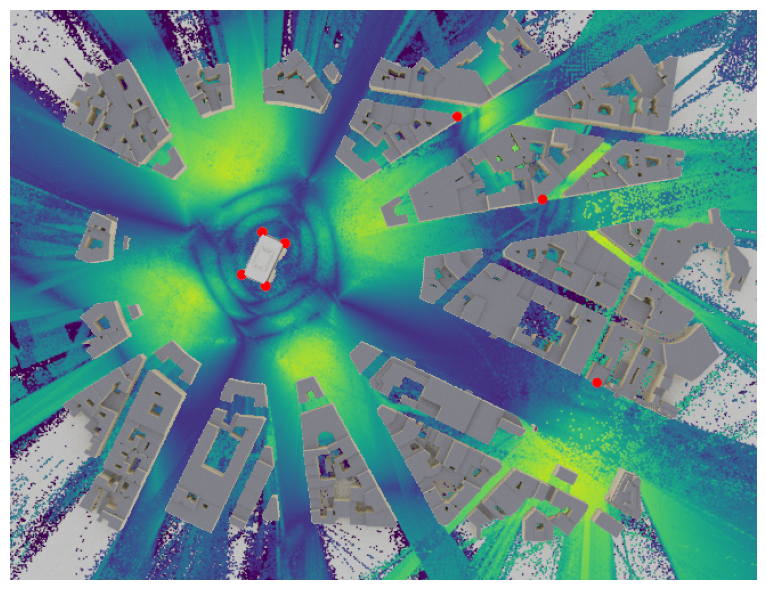

In [17]:
if no_preview:
    # Render an image
    cam = Camera(position=[0,0,1000],
                     orientation=np.array([0,np.pi/2,-np.pi/2]))
    scene_etoile.render(camera=cam,
                        radio_map=rm_etoile,
                        rm_metric="sinr",
                        rm_vmin=-10,
                        rm_vmax=60);
else:
    # Show preview
    scene_etoile.preview(radio_map=rm_etoile,
                         rm_metric="sinr",
                         rm_vmin=-10,
                         rm_vmax=60)

### Channel impulse responses for random user locations

With a radio map at hand, we can now sample random positions at which we place actual receivers and then compute channel impulse responses.

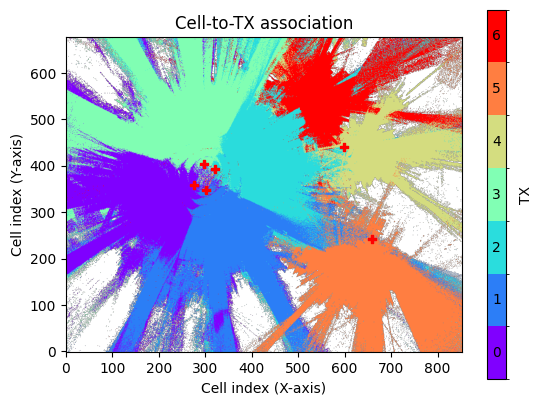

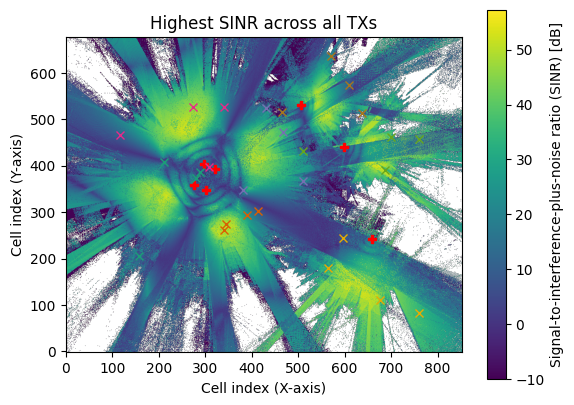

In [18]:
rm_etoile.show_association("sinr");

pos, cell_ids = rm_etoile.sample_positions(
          num_pos=4,         
          metric="sinr",       
          min_val_db=3,        
          min_dist=10,
          max_dist=200,
          tx_association=True)

fig = rm_etoile.show(metric="sinr", vmin=-10);

# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])

In [19]:
[scene_etoile.remove(rx.name) for rx in scene_etoile.receivers.values()]
for i in range(rm_etoile.num_tx):
    for j in range(pos.shape[1]):
        scene_etoile.add(Receiver(name=f"rx-{i}-{j}",
                           position=pos[i,j]))

p_solver = PathSolver()
paths = p_solver(scene_etoile, max_depth=5)

# Channel impulse response
a, tau = paths.cir()

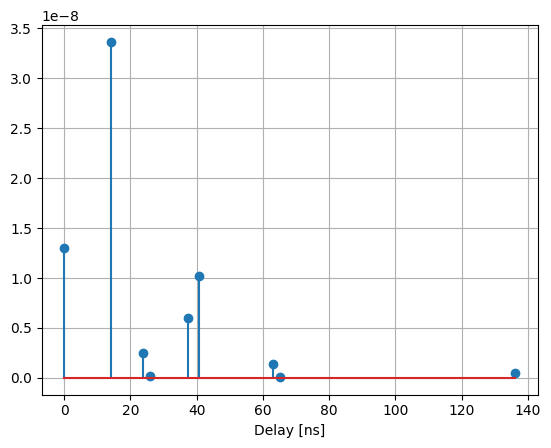

In [20]:
# Transmitter and receiver indices to plot the channel impulse response
tx_index = 0
rx_index = 0

# Compute the squared magnitude of the path coefficients
a_abs_square = cpx_abs_square(a)
# # Sum over the transmit antennas
a_abs_square = np.sum(a_abs_square, axis=3)

# Get the selected path coefficients and delays in ns
a_abs_square = np.squeeze(a_abs_square)[rx_index, tx_index]
tau_ns = np.squeeze(tau)[rx_index, tx_index]*1e9

# Only keep the valid paths
valid = paths.valid.numpy()
valid = valid[rx_index, tx_index]
a_abs_square = a_abs_square[valid]
tau_ns = tau_ns[valid]

# Plot the channel impulse response
plt.figure()
plt.stem(tau_ns, a_abs_square)
plt.xlabel("Delay [ns]")
plt.grid(True)

## Radio maps on meshes

Until now, we have focused on radio maps defined by planar regular grids of cells. However,
Sionna RT can also of compute radio maps for arbitrary meshes.
In this case, each primitive, i.e., each triangle of the mesh, acts as a cell for the radio map computation.

To illustrate this, let's first consider an empty scene before progressing to a more advanced setup.

In [21]:
# Empty scene
scene = load_scene()

# Use a single antenna with directive pattern
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             pattern="tr38901",
                             polarization="V")

# Add a transmitter
scene.add(Transmitter(name="tx",
                      position=[0, 0, 0],
                      orientation=[0, 0, 0]))

We will now load a sphere mesh and calculate the radio map for it.

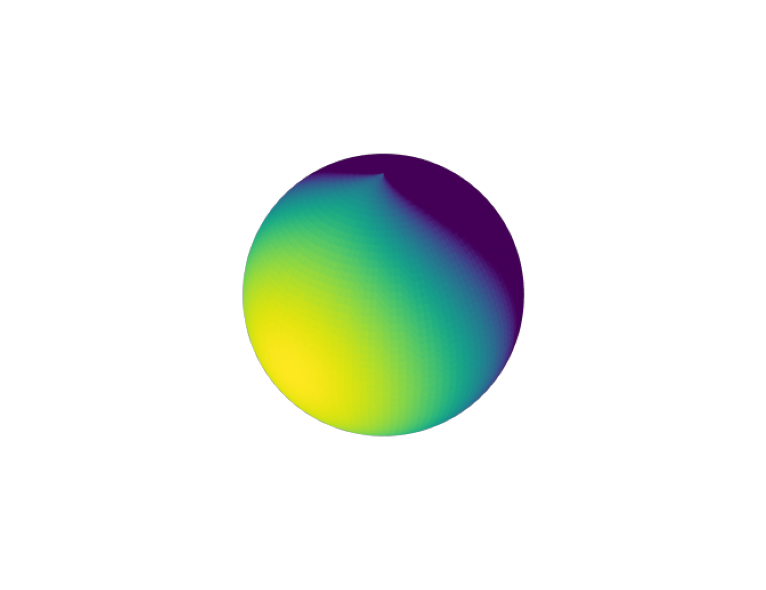

In [22]:
# Load the mesh of a sphere
sphere = load_mesh(sionna.rt.scene.sphere)

# Instantiate the radio map solver
rm_solver = RadioMapSolver()

# Compute radio map using the sphere as the measurement surface
rm = rm_solver(scene,
               measurement_surface=sphere,
               samples_per_tx=10**7)

if no_preview:
    cam = Camera(position=[4, 3, 4])
    cam.look_at(np.array([0, 0, 0]))
    scene.render(camera=cam,
                 radio_map=rm);
else:
    scene.preview(radio_map=rm);

With the sphere centered at the origin and the transmitter also positioned at the origin, this configuration enables the visualization of the antenna pattern as it is projected onto the sphere.
This configuration is equally effective for visualizing the beam pattern of an
antenna array. In contrast to a planar radio map, the resoultion of the
measurement surface is determined by the size of the primitives which cannot be
configured on-the-fly. If you want a
higher resolution, you must use a surface with a finer mesh.

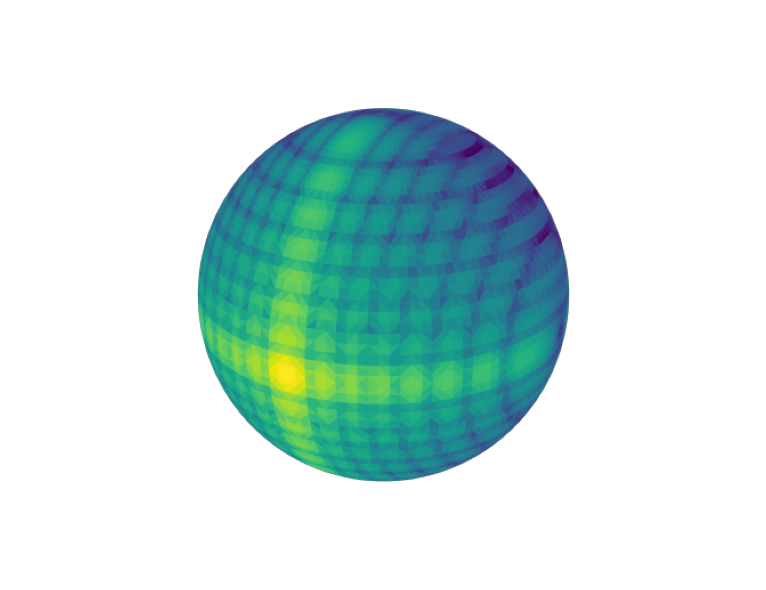

In [23]:
# Use an 16x16 antenna array with directive pattern
scene.tx_array = PlanarArray(num_rows=16,
                             num_cols=16,
                             pattern="tr38901",
                             polarization="V")

# Compute radio map using the sphere as the measurement surface
rm = rm_solver(scene,
               measurement_surface=sphere,
               samples_per_tx=10**7)

if no_preview:
    cam = Camera(position=[4, 2, 2])
    cam.look_at(np.array([0, 0, 0]))
    scene.render(camera=cam,
                 radio_map=rm);
else:
    scene.preview(radio_map=rm);

Let's now explore a more realistic scenario.

One practical application of mesh-based radio maps is to compute them for terrains with arbitrary shapes. To demonstrate this, we'll load a scene featuring a complex terrain.

In [24]:
# Load a scene with a complex terrain
scene = load_scene(sionna.rt.scene.san_francisco)

# Use a single antenna with isotropic pattern
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             pattern="iso",
                             polarization="V")

# Add a transmitter+
scene.add(Transmitter(name="tx",
                      position=[468, 106, 70],
                      orientation=[0, 0, 0],
                      display_radius=5))

We are now going to generate a radio map for a surface that mirrors the terrain's shape and runs parallel to it, positioned 1.5 meters higher.
To achieve this, we will clone the terrain from the scene and shift it upwards along the z-axis.

In [25]:
# Clone the terrain mesh
mesurement_surface = scene.objects["Terrain"].clone(as_mesh=True)
# Shift the terrain upwards by 1.5 meters
transform_mesh(mesurement_surface, translation=np.array([0, 0, 1.5]))

Next, we will calculate a radio map for the measurement surface.

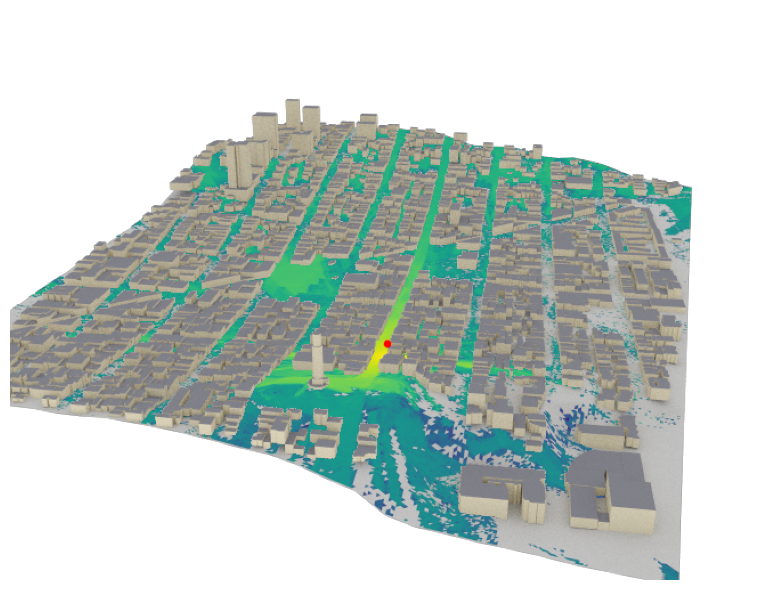

In [26]:
# Compute radio map using the measurement surface
rm = rm_solver(scene,
               measurement_surface=mesurement_surface,
               samples_per_tx=10**8,
               max_depth=5)

if no_preview:
    cam = Camera(position=[1400, 400, 575])
    cam.look_at(np.array([310, 50, 60]))
    scene.render(camera=cam,
                 radio_map=rm);
else:
    scene.preview(radio_map=rm, rm_vmin=-100);

The complex terrain structure significantly affects the coverage, as illustrated here. The red sphere marks the transmitter's position.

## Conclusions

Radio maps are a highly versatile feature of Sionna RT. They are particularly
useful for defining meaningful areas for random user drops that meet certain
constraints on RSS or SINR, or for investigating the placement and
configuration of transmitters in a scene.

However, we have barely scratched the surface of their potential. For example,
observe that the metrics of a radio map are differentiable with respect to most
scene parameters, such as transmitter orientations, transmit power, antenna
patterns, precoding vectors, and so on. This
opens up a wide range of possibilities for gradient-based optimization.

We hope you found this tutorial on radio maps in Sionna RT informative. We
encourage you to get your hands on it, conduct your own experiments and deepen your understanding
of ray tracing. There's always more to learn, so be sure to explore our other
[tutorials](https://nvlabs.github.io/sionna/rt/tutorials.html) as well!